<a href="https://colab.research.google.com/github/Morningspread/Angry-Tweeter/blob/main/Inference_Fear_Anger_Twit_COVID19_223K_March9%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#I want to work on creating a way to better understanding with our inference 

Path to models...


1.   /content/drive/MyDrive/Sean/Emoclass/Model_Anger_10words_70acc_Feb25,2023
2.   /content/drive/MyDrive/Sean/Emoclass/Model_Anger_75words_71acc_Feb28,2023
3. /content/drive/MyDrive/Sean/Emoclass/Model_Fear_151K_11words_75acc_Feb24,2023
4. /content/drive/MyDrive/Sean/Emoclass/Model_Fear_78acc_75words_Feb17b,2022

Requirements
All the models need to be trained on the same input length... 






In [ ]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This is supposed to help us navigate to our folder... 

import os
os.chdir('/content/drive/MyDrive/Sean/Emoclass')

In [ ]:
#Loading the dependencies.. 

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 

#Loading the tokenizers...

from tensorflow.keras.preprocessing.text import Tokenizer

#Importing the pad sequence... 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#Setting maximum column length to display
pd.options.display.max_columns = None


#Load Training models 

In [ ]:
# Load trained models - only need to do this once per run... 

anger_model_10 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Anger_10words_70acc_Feb25,2023')
anger_model_75 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Anger_75words_71acc_Feb28,2023')
fear_model_10 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Fear_151K_11words_75acc_Feb24,2023')
fear_model_75 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Fear_78acc_75words_Feb17b,2022')


In [ ]:
# Load inference dataset... 

df = pd.read_csv("/content/drive/MyDrive/Sean/Twitter/COVID_223KTweets.csv")

In [ ]:
#Let's check the basic characteristics of this...

df.shape

(223955, 36)

In [ ]:
# rename the 'tweet' column to 'text'
df = df.rename(columns={'tweet': 'text'})

In [ ]:
#Let's get the columns for this thing...

df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'text', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

##Filtering the non-english tweets - 116K english 


In [ ]:
df['language'].value_counts()

en    116687
es     31788
ja     13897
pt     12093
fr      9756
       ...  
hy         2
sd         2
ug         1
am         1
bo         1
Name: language, Length: 67, dtype: int64

In [ ]:
#This filter works... 

df = df[df['language'] == 'en']

##Visual inspection of dataset to see if anything needs removal

In [ ]:
df['text'].head(25)

0     SAFE &amp; EFFECTIVE. Pfizer skipped major cat...
1     @montanamike_tx @CastAwayOne1 Its a very small...
3     Lisa Beardsley-Hardy, GC director of education...
5     West Valley Junior High School will hold a com...
7     Free Covid-19 vaccinations will be provided by...
8     At PARC every Thursday and Sunday from 2 p.m. ...
12    You can find #COVID19 weekly updates and vacci...
13    COVID-19: 'Concerning' increases in hospitalis...
14    The Flu disappeared for 2 whole years?  The wi...
17    @amapresident Vaccine failed! Actuaries Digita...
18    Greenview Ave closed from Carling Ave to Brita...
19    The healthcare provider says they are allowing...
22    @JamesSurowiecki Ivermectin CDC   https://t.co...
25    @DHammy1971 Sad state of affairs. It’s BS. Loa...
27    #Download My Kill #Coronavirus On Contact #Rec...
28    @IslingtonBC Give us a venue to host. We reall...
29    @essigna Time to heal from Covid19, more commu...
31    @POTUS According to NEA records, a $150,00

##Data Cleaning Step 

In [ ]:
# define a function to remove @handles, URLs, hashtags, and apostrophes from a string
def preprocess_text(text):
    text = re.sub(r'@\w+\s?', '', text) # remove @handles
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'#\w+\s?', '', text) # remove hashtags
    text = text.replace("'", "") # remove apostrophes
    text = text.replace("?", "") # remove question marks
    text = text.replace("!", "") # remove exclamation marks
    return text

# apply the function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)


In [ ]:
df['text'].head(15)

0     SAFE &amp; EFFECTIVE. Pfizer skipped major cat...
1     Its a very small cohort but it represented unv...
3     Lisa Beardsley-Hardy, GC director of education...
5     West Valley Junior High School will hold a com...
7     Free Covid-19 vaccinations will be provided by...
8     At PARC every Thursday and Sunday from 2 p.m. ...
12    You can find weekly updates and vaccine inform...
13    COVID-19: Concerning increases in hospitalisat...
14    The Flu disappeared for 2 whole years  The win...
17    Vaccine failed Actuaries Digital Report states...
18    Greenview Ave closed from Carling Ave to Brita...
19    The healthcare provider says they are allowing...
22    Ivermectin CDC     Regular Use of Ivermectin a...
25    Sad state of affairs. It’s BS. Loads of compan...
27                               My Kill On Contact    
Name: text, dtype: object

In [ ]:
#Counting word frequency...

# count the number of words in each tweet
df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))

In [ ]:
df['num_words'].describe()

count    116687.000000
mean         24.432756
std          12.893197
min           0.000000
25%          13.000000
50%          23.000000
75%          35.000000
max          70.000000
Name: num_words, dtype: float64

In [ ]:
#Count the frequency below a certain threshold - should we apply a cutoff? 
#Frequency is 5... 

freq = df['num_words'].value_counts()
freq_below_5 = freq[freq < 5]

# print the frequency counts
print(freq_below_5)


61    4
63    2
62    2
67    1
70    1
66    1
Name: num_words, dtype: int64


In [ ]:
#Total number of words below or some other threshold... 

# count the number of tweets with less than 5 words
freq = df['num_words'].value_counts()
threshold = 5
num_tweets_below_threshold = freq[freq.index < threshold].sum()

# print the total number of tweets below the threshold
print("Total number of tweets below {} words: {}".format(threshold, num_tweets_below_threshold))


Total number of tweets below 5 words: 3265


In [ ]:
df.columns 


Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'text', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'num_words'],
      dtype='object')

In [ ]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,text,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,num_words
0,1578109493392515073,1578109493392515073,2022-10-06 19:46:37 UTC,2022-10-06,19:46:37,0,1518980837135589376,krystynaklepin1,Christine K.,NaN,SAFE &amp; EFFECTIVE. Pfizer skipped major cat...,en,[],[],[],0,0,0,[],[],https://twitter.com/KrystynaKlepin1/status/157...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,41
1,1578109461184454656,1578101418317082624,2022-10-06 19:46:30 UTC,2022-10-06,19:46:30,0,1497906018029907970,turdfur58439807,BlackSanta9111,NaN,Its a very small cohort but it represented unv...,en,[],[],['https://pbs.twimg.com/media/FeaR-nlXEBsl6BB....,0,0,1,[],[],https://twitter.com/TurdFur58439807/status/157...,False,NaN,1,https://pbs.twimg.com/media/FeaR-nlXEBsl6BB.jpg,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'montanamike_tx', 'name': 'mi...",NaN,NaN,NaN,NaN,26
3,1578109438464241666,1578087822858522630,2022-10-06 19:46:24 UTC,2022-10-06,19:46:24,0,16635842,spectrummag,SPECTRUM (Since 1969),NaN,"Lisa Beardsley-Hardy, GC director of education...",en,[],[],['https://pbs.twimg.com/media/FeaSGnfaYAAdYva....,0,0,0,['gcac22'],[],https://twitter.com/spectrummag/status/1578109...,False,NaN,1,https://pbs.twimg.com/media/FeaSGnfaYAAdYva.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,34
5,1578109398215426048,1578109398215426048,2022-10-06 19:46:15 UTC,2022-10-06,19:46:15,0,36803382,yakimahealth,Yakima Health District,NaN,West Valley Junior High School will hold a com...,en,[],['http://YakimaVaccines.org'],['https://pbs.twimg.com/media/FeaSIlqXwAA3uLw....,0,0,0,[],[],https://twitter.com/yakimahealth/status/157810...,False,NaN,1,https://pbs.twimg.com/media/FeaSIlqXwAA3uLw.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,39
7,1578109382625067008,1578109382625067008,2022-10-06 19:46:11 UTC,2022-10-06,19:46:11,0,1550501740956422147,smslausd,Student Medical Services & Medi-Cal Programs L...,NaN,Free Covid-19 vaccinations will be provided by...,en,"[{'screen_name': 'lovewfhc', 'name': 'wfhc', '...",[],['https://pbs.twimg.com/media/FeaSHNgVIAIcdXg....,0,0,1,[],[],https://twitter.com/SMSLausd/status/1578109382...,False,NaN,1,https://pbs.twimg.com/media/FeaSHNgVIAIcdXg.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,27


In [ ]:
# select only the 'tweet' column - consistent with the 

text = df['text']


#Tokenizing and Padding 

##Optional step: Text to list -> not a problem... 

In [ ]:
# Define functions for tokenizing and padding
def tokenize_and_pad_sequences(text, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len, padding='post')
    return padded_sequences


In [ ]:
# Tokenize and pad input sequences
tokenizer = Tokenizer(num_words=93886, oov_token='<UNK>')
tokenizer.fit_on_texts(text)
padded_sequences_400 = tokenize_and_pad_sequences(text, tokenizer, 400)
padded_sequences_300 = tokenize_and_pad_sequences(text, tokenizer, 300)

# Generate the predictions
anger_10_preds = np.argmax(anger_model_10.predict(padded_sequences_400), axis=-1)
anger_75_preds = np.argmax(anger_model_75.predict(padded_sequences_400), axis=-1)
fear_10_preds = np.argmax(fear_model_10.predict(padded_sequences_300), axis=-1)
fear_75_preds = np.argmax(fear_model_75.predict(padded_sequences_400), axis=-1)

# Create dataframe of predictions
pred_df = pd.DataFrame({
    'text': text,
    'anger_10': anger_10_preds,
    'anger_75': anger_75_preds,
    'fear_10': fear_10_preds,
    'fear_75': fear_75_preds
})


3647/3647 [==============================] - 135s 37ms/step


#Exploring the inference dataset - sample size!?!? 

In [ ]:
#What are the dimensions? 

pred_df.shape

(116687, 5)

In [ ]:
#pred_df.tail(25)

pred_df

,text,anger_10,anger_75,fear_10,fear_75
0,SAFE &amp; EFFECTIVE. Pfizer skipped major cat...,1,2,5,4
1,Its a very small cohort but it represented unv...,4,4,4,3
3,"Lisa Beardsley-Hardy, GC director of education...",4,1,4,0
5,West Valley Junior High School will hold a com...,4,2,1,0
7,Free Covid-19 vaccinations will be provided by...,5,4,1,0
...,...,...,...,...,...
223943,""" Safe and Effective: A Second Opinion shines ...",5,2,4,1
223945,Covid-19 inspired people to circumvent censors...,2,4,4,4
223946,Just like trump caused Covid-19 right,4,4,4,3
223952,Hastings restaurant owner said she was fined b...,5,2,4,4


In [ ]:
pred_df.shape

(116687, 5)

In [ ]:
#Let's look at the correlations? 

pred_df.corr()

,anger_10,anger_75,fear_10,fear_75,anger_diff,fear_diff,anger_total,fear_total,emotion_total,word_count
anger_10,1.000000,-0.012405,0.015945,0.011184,-0.435113,-0.002191,0.796021,0.018680,0.524086,0.085961
anger_75,-0.012405,1.000000,0.006750,0.008034,-0.494175,-0.016126,0.595347,0.010451,0.389311,-0.105358
fear_10,0.015945,0.006750,1.000000,0.008216,-0.019483,0.131025,0.016898,0.637437,0.491619,0.017480
fear_75,0.011184,0.008034,0.008216,1.000000,-0.005348,-0.622230,0.013850,0.775714,0.593962,0.061381
anger_diff,-0.435113,-0.494175,-0.019483,-0.005348,1.000000,0.003358,-0.648759,-0.016417,-0.428031,0.032111
fear_diff,-0.002191,-0.016126,0.131025,-0.622230,0.003358,1.000000,-0.011522,-0.396755,-0.306637,-0.002808
anger_total,0.796021,0.595347,0.016898,0.013850,-0.648759,-0.011522,1.000000,0.021336,0.656775,0.005298
fear_total,0.018680,0.010451,0.637437,0.775714,-0.016417,-0.396755,0.021336,1.000000,0.767928,0.058328
emotion_total,0.524086,0.389311,0.491619,0.593962,-0.428031,-0.306637,0.656775,0.767928,1.000000,0.047389
word_count,0.085961,-0.105358,0.017480,0.061381,0.032111,-0.002808,0.005298,0.058328,0.047389,1.000000


In [ ]:
pred_df.describe()

,anger_10,anger_75,fear_10,fear_75
count,116687.000000,116687.000000,116687.000000,116687.000000
mean,3.633378,3.481322,3.358018,2.026541
std,1.511424,1.138586,1.397540,1.706280
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,3.000000,0.000000
50%,4.000000,4.000000,4.000000,2.000000
75%,5.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116687 entries, 0 to 223953
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      116687 non-null  object
 1   anger_10  116687 non-null  int64 
 2   anger_75  116687 non-null  int64 
 3   fear_10   116687 non-null  int64 
 4   fear_75   116687 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 5.3+ MB


In [ ]:
#The code computes value counts in a number of columnss and creates a dataframe out of the results... 

non_text_cols = ['anger_10', 'anger_75', 'fear_10', 'fear_75']
value_counts = {}

for col in non_text_cols:
    value_counts[col] = pred_df[col].value_counts()

df_value_counts = pd.DataFrame(value_counts)

In [ ]:
df_value_counts

,anger_10,anger_75,fear_10,fear_75
0,10365,5078,7190,34644
1,3668,4601,14396,22368
2,12108,14373,4297,2395
3,529,87,4285,24386
4,55588,90123,76603,28315
5,34429,2425,9916,4579


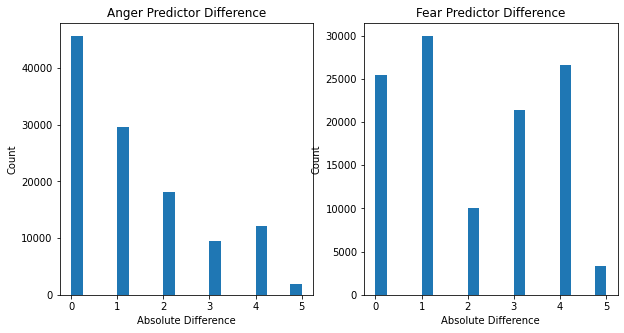

In [ ]:
# Calculate absolute differences
pred_df['anger_diff'] = abs(pred_df['anger_10'] - pred_df['anger_75'])
pred_df['fear_diff'] = abs(pred_df['fear_10'] - pred_df['fear_75'])

# Plot histograms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].hist(pred_df['anger_diff'], bins=20)
axes[0].set_xlabel('Absolute Difference')
axes[0].set_ylabel('Count')
axes[0].set_title('Anger Predictor Difference')

axes[1].hist(pred_df['fear_diff'], bins=20)
axes[1].set_xlabel('Absolute Difference')
axes[1].set_ylabel('Count')
axes[1].set_title('Fear Predictor Difference')

plt.show()


In [ ]:
#Value counts for the differences....

print(pred_df['anger_diff'].value_counts())
print(pred_df['fear_diff'].value_counts())


0    45659
1    29632
2    18046
4    12067
3     9466
5     1817
Name: anger_diff, dtype: int64
1    29968
4    26580
0    25420
3    21361
2    10073
5     3285
Name: fear_diff, dtype: int64


#Defining labels for the emotions 

In [ ]:
# Define emotion labels
anger_labels = ['calm', 'annoyed', 'agitated', 'frustrated', 'angry', 'rage']
fear_labels = ['calm', 'concern', 'worry', 'anxiety', 'fear', 'dread']

# Define mapping from integer label to emotion label
anger_label_map = {i: label for i, label in enumerate(anger_labels)}
fear_label_map = {i: label for i, label in enumerate(fear_labels)}

# Add columns for predicted emotion label
pred_df['anger_10_label'] = pred_df['anger_10'].map(anger_label_map)
pred_df['anger_75_label'] = pred_df['anger_75'].map(anger_label_map)
pred_df['fear_10_label'] = pred_df['fear_10'].map(fear_label_map)
pred_df['fear_75_label'] = pred_df['fear_75'].map(fear_label_map)


#Creating the sum variables

In [ ]:
pred_df['anger_total'] = pred_df['anger_10'] + pred_df['anger_75']
pred_df['fear_total'] = pred_df['fear_10'] + pred_df['fear_75']
pred_df['emotion_total'] = pred_df['anger_total'] + pred_df['fear_total']

In [ ]:
pred_df['anger_total'].value_counts().sort_index()

0       402
1       650
2      1712
3       993
4     12029
5      6752
6     17911
7      5030
8     43001
9     27490
10      717
Name: anger_total, dtype: int64

In [ ]:
#The code computes value counts in a number of columnss and creates a dataframe out of the results... 

non_text_cols = ['anger_10', 'anger_75', 'fear_10', 'fear_75']
value_counts = {}

for col in non_text_cols:
    value_counts[col] = pred_df[col].value_counts()

df_value_counts = pd.DataFrame(value_counts)

In [ ]:
#Checking the dataset...

df_value_counts

,anger_10,anger_75,fear_10,fear_75
0,10365,5078,7190,34644
1,3668,4601,14396,22368
2,12108,14373,4297,2395
3,529,87,4285,24386
4,55588,90123,76603,28315
5,34429,2425,9916,4579


In [ ]:
#Looking at the correlation matrix...

pred_df.corr()

,anger_10,anger_75,fear_10,fear_75,anger_diff,fear_diff,anger_total,fear_total,emotion_total
anger_10,1.000000,-0.012405,0.015945,0.011184,-0.435113,-0.002191,0.796021,0.018680,0.524086
anger_75,-0.012405,1.000000,0.006750,0.008034,-0.494175,-0.016126,0.595347,0.010451,0.389311
fear_10,0.015945,0.006750,1.000000,0.008216,-0.019483,0.131025,0.016898,0.637437,0.491619
fear_75,0.011184,0.008034,0.008216,1.000000,-0.005348,-0.622230,0.013850,0.775714,0.593962
anger_diff,-0.435113,-0.494175,-0.019483,-0.005348,1.000000,0.003358,-0.648759,-0.016417,-0.428031
fear_diff,-0.002191,-0.016126,0.131025,-0.622230,0.003358,1.000000,-0.011522,-0.396755,-0.306637
anger_total,0.796021,0.595347,0.016898,0.013850,-0.648759,-0.011522,1.000000,0.021336,0.656775
fear_total,0.018680,0.010451,0.637437,0.775714,-0.016417,-0.396755,0.021336,1.000000,0.767928
emotion_total,0.524086,0.389311,0.491619,0.593962,-0.428031,-0.306637,0.656775,0.767928,1.000000


In [ ]:
#Let's look at the distributions...

pred_df.describe()

,anger_10,anger_75,fear_10,fear_75,anger_diff,fear_diff,anger_total,fear_total,emotion_total
count,116687.000000,116687.000000,116687.000000,116687.000000,116687.000000,116687.000000,116687.000000,116687.000000,116687.000000
mean,3.633378,3.481322,3.358018,2.026541,1.298131,2.030578,7.114700,5.384559,12.499259
std,1.511424,1.138586,1.397540,1.706280,1.400514,1.573178,1.880979,2.214429,2.935902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,3.000000,0.000000,0.000000,1.000000,6.000000,4.000000,11.000000
50%,4.000000,4.000000,4.000000,2.000000,1.000000,2.000000,8.000000,5.000000,13.000000
75%,5.000000,4.000000,4.000000,4.000000,2.000000,4.000000,8.000000,7.000000,15.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,10.000000,10.000000,20.000000


In [ ]:
pred_df['fear_10'].value_counts().sort_index()

0     7190
1    14396
2     4297
3     4285
4    76603
5     9916
Name: fear_10, dtype: int64

#Merging Classification Dataset with Other Variables... 

Requirements: both datasets need to be the same size...

Merge on text 

In [ ]:
#Checking the size of the dataset: 
#Pred_df: (116687, 14)
#df: (116687, 37)

pred_df.shape

(116687, 14)

In [ ]:
# merge the two datasets on the 'text' column
merged_df = pd.merge(df, pred_df, on='text')

In [ ]:
#Let's check the shape of the new dataframe....
merged_df.shape

(373123, 50)

#Error Prediction Analysis 

In [ ]:
pred_df['word_count'] = pred_df['text'].apply(lambda x: len(x.split()))

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = pred_df[['word_count', 'anger_10', 'anger_75']]
y = pred_df['fear_diff']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
rf_score = rf.score(X_test, y_test)
print(f'Random Forest R^2 score: {rf_score:.4f}')

# Get the feature importance and print it out
feature_importance = rf.feature_importances_
print('Feature Importance:')
print(f'Word Count: {feature_importance[0]:.4f}')
print(f'Anger_10: {feature_importance[1]:.4f}')
print(f'Anger_75: {feature_importance[2]:.4f}')
#print(f'Fear_10: {feature_importance[3]:.4f}')
#print(f'Fear_75: {feature_importance[4]:.4f}')


Random Forest R^2 score: 0.0560
Feature Importance:
Word Count: 0.7444
Anger_10: 0.1338
Anger_75: 0.1218


#Exporting the dataset

In [ ]:
path = "/content/drive/MyDrive/Sean/Emoclass/inference_COVID19_223K_March9b,2023.csv"
pred_df.to_csv(path)